In [1]:
import os
from PIL import Image
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm

from keras import backend as k
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,AveragePooling2D,Dropout,BatchNormalization
from keras.activations import relu,softmax
from keras.initializers import he_normal,glorot_normal,random_normal,glorot_uniform
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta,Adam
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

*Preprocessing*

*1.Collect the image data in a list*

*2.Resize the data*

*3.convert into numpy and normalize and then store to Drive.*


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
labels = {'Amphibia':0,'Animalia':1 ,'Arachnida':2 ,'Aves':3 , 'Fungi':4 ,'Insecta':5 ,'Mammalia':6 , 'Mollusca':7,
          'Plantae':8 , 'Reptilia':9}

In [3]:
#take a list of PIL images..
def plot_images(X ,Y):
  plt.figure(figsize=(16,7)) 

  indices = [Y.index(ele) for ele in set(Y)]
  Y_sample = [Y[i] for i in indices]
  X_sample = [X[i] for i in indices]

  for i in range(len(indices)):
    plt.subplot(2,5,i+1).set_title(Y_sample[i])
    #im = mpimg.imread(X_sample[i])
    plt.imshow(X_sample[i])
    plt.axis('off')
  
  plt.suptitle("Sample Images From the Train Dataset")
  plt.show()
  return


In [4]:
#path--> path of the inaturalist_12k directory
#train_sample --> number of train sample for each class
#test_sample  --> number of test sample for each class.
#resize them to the (train_min_height , train_min_width)

def Collect_Data(path , train_sample , test_sample ,width ,height):
  X_tr=[];Y_tr=[];X_ts=[] ;Y_ts=[]

  train_root = path+'/train/'
  #get each folder in train...
  classes = os.listdir(train_root)
  print('Getting Train data from directory...')
  for cls in tqdm(classes):
    #get the class folder...
    class_path = train_root+cls+'/'

    #>>Sample Size For Train
    count=train_sample
    for img in os.listdir(class_path):
      count-=1
      s_i = Image.open(class_path+img)
      X_tr.append(s_i)
      Y_tr.append(cls)
      if count==0:
        break
  print('Resizing train data..')
  for i in tqdm(range(len(X_tr))):
    X_tr[i] = X_tr[i].resize((width,height),Image.ANTIALIAS)

  test_root = path+'/val/'
  #get each folder in train...
  classes = os.listdir(test_root)
  print("Collecting test data...")
  for cls in tqdm(classes):
  #get the class folder...
    class_path = test_root+cls+'/'
    #>>Sample size for test...
    count=test_sample
    for img in os.listdir(class_path):
      count-=1
      X_ts.append(s_i)
      Y_ts.append(cls)
      if count==0:
        break
  print("Resizing test data...")
  for i in tqdm(range(len(X_ts))):
    X_ts[i] = X_ts[i].resize((width,height),Image.ANTIALIAS)

  return (X_tr , Y_tr, X_ts ,Y_ts)

In [5]:
#The inaturalist folder should be there in google drive..
def Store_in_Drive(trsmple , tssmple ,width , height):


  path ='/content/gdrive/MyDrive/inaturalist_12K'
  X_tr_img ,Y_tr_img ,X_ts_img ,Y_ts_img =Collect_Data(path,trsmple,tssmple ,width ,height)

  print('storing raw data in Drive..')
  os.mkdir('/content/gdrive/MyDrive/Raw_data')
  with open('/content/gdrive/MyDrive/Raw_data/xtrimg','wb') as f:
    pickle.dump(X_tr_img , f)
  with open('/content/gdrive/MyDrive/Raw_data/xtsimg','wb') as f:
    pickle.dump(X_ts_img , f)
  with open('/content/gdrive/MyDrive/Raw_data/ytrimg','wb') as f:
    pickle.dump(Y_tr_img , f)
  with open('/content/gdrive/MyDrive/Raw_data/ytsimg','wb') as f:
    pickle.dump(Y_ts_img , f)
  print('raw data stored in drive...')
  return

In [30]:
#Mount the drive ...
#250 samples from each class are taken for train data and each image is resized to 300x300.
Store_in_Drive(trsmple=700 ,tssmple=200 ,width=150 , height=150)

Getting Train data from directory...



Resizing train data..



Resizing test data...



storing raw data in Drive..
raw data stored in drive...


In [6]:
with open('/content/gdrive/MyDrive/Raw_data/xtrimg','rb') as f:
      X_tr_img = pickle.load(f)
with open('/content/gdrive/MyDrive/Raw_data/xtsimg','rb') as f:
      X_ts_img = pickle.load(f)
with open('/content/gdrive/MyDrive/Raw_data/ytrimg','rb') as f:
      Y_tr_img = pickle.load(f)
with open('/content/gdrive/MyDrive/Raw_data/ytsimg','rb') as f:
      Y_ts_img = pickle.load(f)

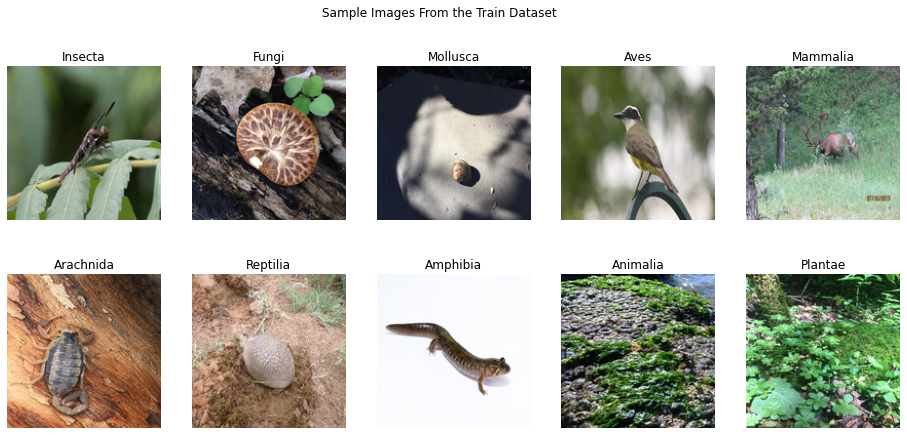

In [7]:
plot_images(X_tr_img , Y_tr_img)

In [8]:
for i in range(len(X_tr_img)):
  X_tr_img[i] = (np.array(X_tr_img[i])/255)

X_tr_img = np.array(X_tr_img)

In [9]:
for i in range(len(X_ts_img)):
   X_ts_img[i] = (np.array(X_ts_img[i])/255)

X_ts_img = np.array(X_ts_img)

In [10]:
Y_tr_img = list(map(lambda x:labels[x] , Y_tr_img))
Y_ts_img = list(map(lambda x:labels[x] , Y_ts_img))

Y_tr_ohe = np_utils.to_categorical(Y_tr_img ,len(labels))
Y_ts_ohe = np_utils.to_categorical(Y_ts_img ,len(labels))

In [11]:
#Train test split..
X_tr_img , X_cv_img , Y_tr_img , Y_cv_img = train_test_split(X_tr_img ,Y_tr_ohe ,test_size = 0.1 ,stratify = Y_tr_ohe)

*Loading the data...*

In [12]:
print("Train Data Shape :",X_tr_img.shape)
print("Validation Data Shape :",X_cv_img.shape)
print("Test Data Shape :",X_ts_img.shape)

Train Data Shape : (6300, 150, 150, 3)
Validation Data Shape : (700, 150, 150, 3)
Test Data Shape : (2000, 150, 150, 3)


Question 1 (5 Marks)
Build a small CNN model consisting of 5 convolution layers. Each convolution layer would be followed by a ReLU activation and a max pooling layer. Here is sample code for building one such conv-relu-maxpool block in keras.

model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
After 5 such conv-relu-maxpool blocks of layers you should have one dense layer followed by the output layer containing 10 neurons (1 for each of the 10 classes). The input layer should be compatible with the images in the iNaturalist dataset.

The code should be flexible such that the number of filters, size of filters and activation function in each layer can be changed. You should also be able to change the number of neurons in the dense layer. 

In [13]:
if k.image_data_format()=='channels_first':
  X_tr_img = np.moveaxis(X_tr_img,3,1)
  X_ts_img = np.moveaxis(X_ts_img,3,1)

In [14]:
#Activation function should also be changed for each layer..
class CNN_MODEL:

  def __init__(self,input_shape,num_filters,filter_size,filter_organisation,num_neurons,data_aug,dropout,BN,num_outputs):

    self.model = Sequential()
    self.input_shape = input_shape
    self.num_filters = num_filters
    self.filter_size = filter_size
    self.filter_organisation = filter_organisation
    self.num_neurons =num_neurons
    self.data_aug = data_aug
    self.dropout = dropout
    self.BN = BN
    self.num_outputs = num_outputs

  def BUILD_MODEL(self):
    
    #Build 1st layer...
    self.model.add(Conv2D(filters = self.num_filters ,kernel_size =self.filter_size,use_bias = True,
                          activation = 'relu' ,input_shape=input_shape))
    #self.model.add(Activation('relu'))
    self.model.add(MaxPooling2D(pool_size=(2,2)))

    cur_filters = self.num_filters 
    for i in range(1,5):

      if self.filter_organisation == 'same':
        pass
      
      elif self.filter_organisation == 'double':
        cur_filters*=2
      else:
        cur_filters*=0.5

      self.model.add(Conv2D(filters = cur_filters , kernel_size = self.filter_size ,use_bias= True ,activation = 'relu'))
      #self.model.add(Activation('relu'))
      self.model.add(MaxPooling2D(pool_size=(2,2)))
    
    self.model.add(Flatten())
    self.model.add(Dense(units=self.num_neurons ,activation='relu'))
    if self.BN == 'Yes':
      self.model.add(BatchNormalization())
    
    self.model.add(Dropout(self.dropout))

    self.model.add(Dense(units = self.num_outputs ,activation='softmax'))

    self.model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return 

  def fit_CNN(self , X_tr , Y_tr , X_cv ,Y_cv ,epochs , batch_size):

    if self.data_aug == 1:
      IDG = ImageDataGenerator(zoom_range=0.2 ,horizontal_flip=True ,rotation_range=30 ,shear_range=12)
      IDG.fit(X_tr_img ,augment=True)
      appended_data = IDG.flow(X_tr,Y_tr,batch_size = batch_size)

      fitted_model = self.model.fit_generator(appended_data , epochs=epochs,\
                                steps_per_epoch=X_tr.shape[0]//batch_size,verbose=1,validation_data=(X_cv,Y_cv))

       

    else:
      IDG = -1
      fitted_model = self.model.fit(X_tr , Y_tr , epochs = epochs ,steps_per_epoch = X_tr.shape[0]//batch_size,\
                                    verbose = 1 ,validation_data = (X_cv,Y_cv))
      
    
    return (self.model ,IDG , fitted_model)



In [15]:
input_shape = X_tr_img.shape[1:]

cnn = CNN_MODEL(input_shape = input_shape,
          num_filters = 32,
          filter_size =3,
          filter_organisation ='half',
          num_neurons = 128,
          data_aug = 0,
          dropout = 0,
          BN = False ,
          num_outputs = len(labels))

cnn.BUILD_MODEL() 
cnn.model.summary()      

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 4)         2

In [16]:
cnn.fit_CNN(X_tr_img ,Y_tr_img ,X_cv_img ,Y_cv_img,epochs=20,batch_size=32)

Epoch 1/20
196/196 [==============================] - 34s 17ms/step - loss: 2.2896 - accuracy: 0.1134 - val_loss: 2.2443 - val_accuracy: 0.1543
Epoch 2/20
196/196 [==============================] - 3s 13ms/step - loss: 2.2520 - accuracy: 0.1495 - val_loss: 2.2446 - val_accuracy: 0.1471
Epoch 3/20
196/196 [==============================] - 2s 13ms/step - loss: 2.2143 - accuracy: 0.1690 - val_loss: 2.1331 - val_accuracy: 0.2057
Epoch 4/20
196/196 [==============================] - 3s 13ms/step - loss: 2.1286 - accuracy: 0.2265 - val_loss: 2.1071 - val_accuracy: 0.2271
Epoch 5/20
196/196 [==============================] - 2s 13ms/step - loss: 2.1146 - accuracy: 0.2288 - val_loss: 2.0942 - val_accuracy: 0.2314
Epoch 6/20
196/196 [==============================] - 3s 13ms/step - loss: 2.0826 - accuracy: 0.2420 - val_loss: 2.0952 - val_accuracy: 0.2371
Epoch 7/20
196/196 [==============================] - 3s 13ms/step - loss: 2.0659 - accuracy: 0.2562 - val_loss: 2.0660 - val_accuracy: 0.247

(<tensorflow.python.keras.engine.sequential.Sequential at 0x7fc70de3c150>,
 -1,
 <tensorflow.python.keras.callbacks.History at 0x7fc70e8323d0>)

1.Data Augmentation

2.Model run 